In [6]:
import os
import subprocess
import requests
import pandas as pd
from bs4 import BeautifulSoup
from io import StringIO
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.ticker as ticker
import re

* `scrounge_requests()` collects data from the web using `requests` package and stores data from each year in `.html` formal

In [6]:
def scrounge_requests():
    dir_resource = 'resources/'

    headers = {
        'User-Agent': 'Chrome/90.0.4430.212'
    }

    for year in range(2009, 2025):
        url = f'https://kenpom.com/index.php?y={year}'
        
        # Make the GET request to fetch the page's HTML, with headers
        response = requests.get(url, headers=headers)
        
        if response.status_code == 200:
            file_path = os.path.join(dir_resource, f'{year}.html')
            with open(file_path, 'w', encoding='utf-8') as file:
                file.write(response.text)
            print(f'Saved HTML content for year {year}')
        else:
            print(f"Collection of stats in year {year} failed. Err: {response.status_code}")
            print(response.text)
scrounge_requests()

Collection of stats in year 2009 failed. Err: 403
<!DOCTYPE html><html lang="en-US"><head><title>Just a moment...</title><meta http-equiv="Content-Type" content="text/html; charset=UTF-8"><meta http-equiv="X-UA-Compatible" content="IE=Edge"><meta name="robots" content="noindex,nofollow"><meta name="viewport" content="width=device-width,initial-scale=1"><style>*{box-sizing:border-box;margin:0;padding:0}html{line-height:1.15;-webkit-text-size-adjust:100%;color:#313131}button,html{font-family:system-ui,-apple-system,BlinkMacSystemFont,Segoe UI,Roboto,Helvetica Neue,Arial,Noto Sans,sans-serif,Apple Color Emoji,Segoe UI Emoji,Segoe UI Symbol,Noto Color Emoji}@media (prefers-color-scheme:dark){body{background-color:#222;color:#d9d9d9}body a{color:#fff}body a:hover{color:#ee730a;text-decoration:underline}body .lds-ring div{border-color:#999 transparent transparent}body .font-red{color:#b20f03}body .big-button,body .pow-button{background-color:#4693ff;color:#1d1d1d}body #challenge-success-text

* `scrounge()` collects data from running `scrounge.js` with node  
* `scrounge.js` looks like this:
```javascript
const fs = require('fs');
const fetch = require('node-fetch');
const path = require('path');

const dirResource = 'resources/';

const headers = {
    'User-Agent': 'Chrome/90.0.4430.212'
};

const scrounge = async () => {
    for (let year = 2009; year < 2025; year++) {
        let url = `https://kenpom.com/index.php?y=${year}`;

        if (year === 2024) {
            url = 'https://kenpom.com/';
        }

        try {
            const response = await fetch(url, { headers: headers });

            if (response.ok) {
                const text = await response.text();
                const filePath = path.join(dirResource, `${year}.html`);

                // Ensure the directory exists
                fs.mkdirSync(dirResource, { recursive: true });

                fs.writeFileSync(filePath, text, 'utf-8');
                console.log(`Saved HTML content for year ${year}`);
            } else {
                console.log(`Collection of stats in year ${year} failed. Err: ${response.status}`);
            }
        } catch (error) {
            console.error(`Error fetching data for year ${year}:`, error);
        }
    }
};

scrounge();

```

In [7]:
def scrounge():
    script_path = './scrounge.js'

    # Running the Node.js script using subprocess.run
    try:
        result = subprocess.run(['node', script_path], check=True, capture_output=True, text=True)
        print("Script output:", result.stdout)
    except subprocess.CalledProcessError as e:
        print("Error running script:", e.stderr)

scrounge()


FileNotFoundError: [WinError 2] The system cannot find the file specified

* `check2014` is for investigation of a single dataframe extracted from `.html` file. 
* used for testing purpose **NOT for mainstream data pipeline**

In [4]:
def check2014():
    HEADER = ['Rk','Team','Conf','W','L','AdjEM','AdjO','AdjO_enh','AdjD','AdjD_enh','AdjT','AdjT_enh','Luck','Luck_enh','AdjEM_SoS','AdjEM_enh_SoS','OppO_SoS','OppO_enh_SoS','OppD_SoS','OppD_enh_SoS','AdjEM_NCSOS', 'AdjEM_enh_NCSOS']
    with open('resources/2014.html', 'r') as file:
        html_content = file.read()
        soup = BeautifulSoup(html_content, 'html.parser')
        table = soup.find('table')
        table_html = StringIO(str(table))

        df = pd.read_html(table_html)[0]

        df.columns = [col[-1] for col in df.columns]

        df[['W', 'L']] = df['W-L'].str.split('-', expand=True)
        df.drop('W-L', axis=1, inplace=True)

        conf_index = df.columns.get_loc('Conf') + 1
        df.insert(conf_index, 'W', df.pop('W'))
        df.insert(conf_index + 1, 'L', df.pop('L'))

        df.columns = HEADER
        
        for col in df.columns:
            if col not in ['Team', 'Conf']:
                df[col] = pd.to_numeric(df[col], errors='coerce')

        df['Team'] = df['Team'].str.replace(r'\s+\d+$', '', regex=True)


        print(df['Team'])

check2014()

0                  Louisville
1                     Arizona
2                     Florida
3                    Virginia
4                   Wisconsin
                ...          
362    Mississippi Valley St.
363         Abilene Christian
364              Presbyterian
365             Grambling St.
366             Southern Utah
Name: Team, Length: 367, dtype: object


* `processHTMLS()` parses the `.html` files to `pandas` DataFrame
* Each data from each year is stored in a dictionary : `dataframes`

In [5]:
def processHTMLS():
    dataframes = {}
    HEADER = ['Rk','Team','Conf','W','L','AdjEM','AdjO','AdjO_enh','AdjD','AdjD_enh','AdjT','AdjT_enh','Luck','Luck_enh','AdjEM_SoS','AdjEM_enh_SoS','OppO_SoS','OppO_enh_SoS','OppD_SoS','OppD_enh_SoS','AdjEM_NCSOS', 'AdjEM_enh_NCSOS']
    for year in range(2009, 2025):
        file_path = f'resources/{year}.html'
        with open(file_path, 'r') as file:
            html_content = file.read()
        
        soup = BeautifulSoup(html_content, 'html.parser')
        table = soup.find('table')
        table_html = StringIO(str(table))

        df = pd.read_html(table_html)[0]

        df.columns = [col[-1] for col in df.columns]

        df[['W', 'L']] = df['W-L'].str.split('-', expand=True)
        df.drop('W-L', axis=1, inplace=True)

        conf_index = df.columns.get_loc('Conf') + 1
        df.insert(conf_index, 'W', df.pop('W'))
        df.insert(conf_index + 1, 'L', df.pop('L'))

        df.columns = HEADER

        for col in df.columns:
            if col not in ['Team', 'Conf']:
                df[col] = pd.to_numeric(df[col], errors='coerce')
        
        df['Team'] = df['Team'].str.replace(r'\s+\d+$', '', regex=True)
        dataframes[str(year)] = df
    return dataframes
dfs = processHTMLS()



* `setMplParam()`: is customisation for `Matplotlib`

In [6]:
def setMplParam(classNum):
    COLOUR = ['#1E90FF', '#FFBF00', '#FF6347', '#00A86B', '#5A4FCF','#D473D4', '#00CCFF']
    LINE = ['--', '-', '-.', '-', ':', '--','-']
    MARKER = ['o', 's', '^', '*', '.', 'p', 'o']
    COLOUR_EFF = COLOUR[:classNum]
    LINE_EFF = LINE[:classNum]
    MARKER_EFF = MARKER[:classNum]
    plt.rcParams['axes.prop_cycle'] = (plt.cycler(color=COLOUR_EFF) +
                                        plt.cycler(linestyle=LINE_EFF) +
                                        plt.cycler(marker=MARKER_EFF))
    plt.rcParams['lines.markersize'] = 10  # Example size
    plt.rcParams['lines.linewidth'] = 3  # Example width

    plt.rcParams['axes.labelsize'] = 20
    plt.rcParams['axes.titlesize'] = 20

    plt.rcParams['xtick.direction'] = 'in'
    plt.rcParams['xtick.labelsize'] = 20
    
    plt.rcParams['ytick.direction'] = 'in'
    plt.rcParams['ytick.labelsize'] = 20
    
    plt.rcParams['legend.fontsize'] = 12

    plt.rcParams['axes.grid'] = True
    plt.rcParams['grid.alpha'] = 0.8
    plt.rcParams['grid.linestyle'] = '--'
    plt.rcParams['grid.linewidth'] = 1

    mpl.rcParams['axes.linewidth'] = 2

    mpl.rcParams['xtick.major.size'] = 7
    mpl.rcParams['xtick.major.width'] = 3
    mpl.rcParams['xtick.minor.size'] = 2
    mpl.rcParams['xtick.minor.width'] = 2

    mpl.rcParams['ytick.major.size'] = 7
    mpl.rcParams['ytick.major.width'] = 3
    mpl.rcParams['ytick.minor.size'] = 2
    mpl.rcParams['ytick.minor.width'] = 2

# setMplParam(6)

In [7]:
conferences_5 = ['ACC', 'SEC', 'B10', 'BSky', 'A10']
conferences_6 = ['ACC', 'SEC', 'B10', 'BSky', 'A10', 'BE']

# Ex1

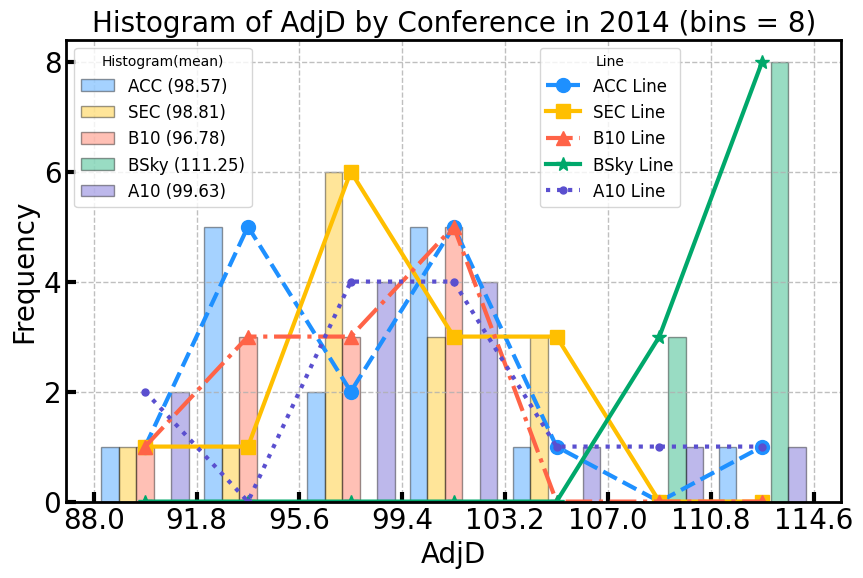

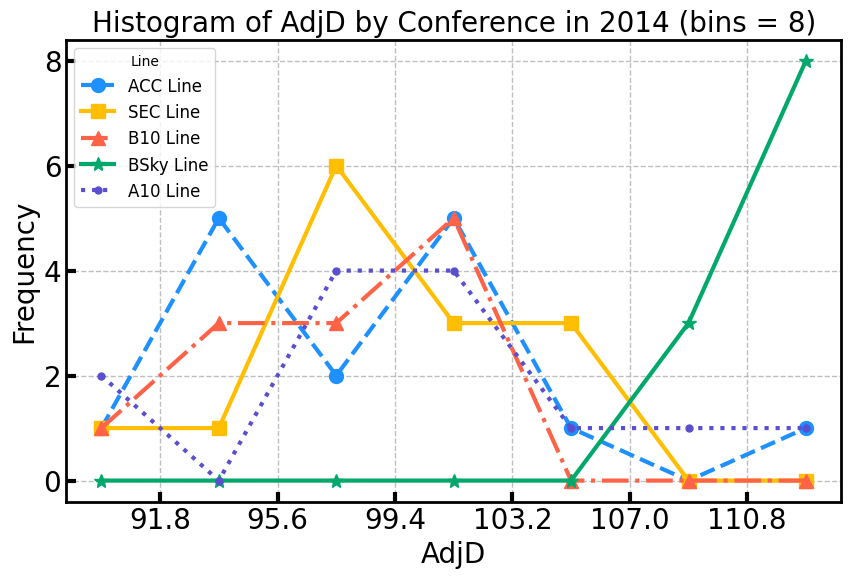

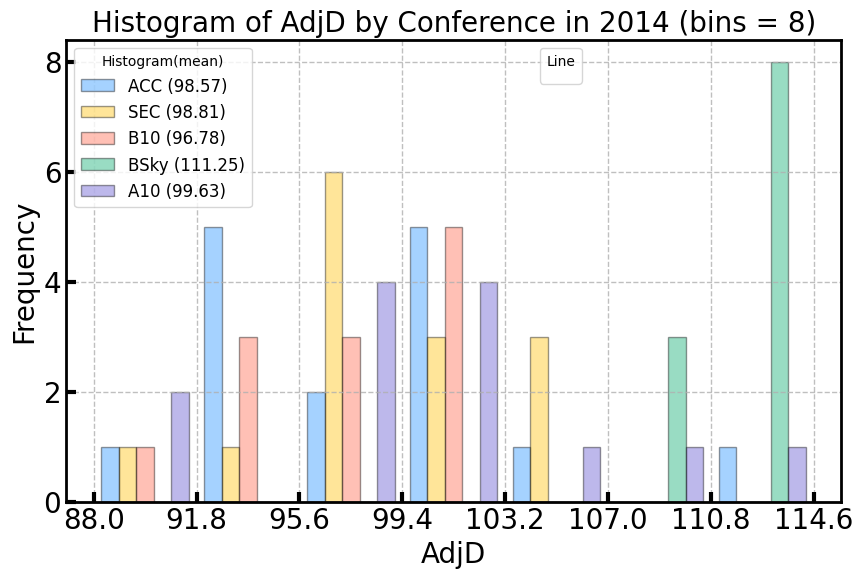

In [32]:
def stats2014_bar(conferences, isBar=True, isBoth=True):
    df14 = dfs['2014']
    df14_conf = {conf: df14[df14['Conf'] == conf]['AdjD'] for conf in conferences}
    all_data = [df14_conf[conf] for conf in conferences]

    global_min = min([min(AdjD) for AdjD in all_data])
    global_max = max([max(AdjD) for AdjD in all_data])

    num_bins = 8
    bar_width = 0.85
    bins = np.linspace(global_min, global_max, num_bins)

    setMplParam(len(conferences))  # Assuming this is a custom function to set matplotlib parameters

    fig, ax = plt.subplots(figsize=(10, 6))

    if isBar:
        # Plotting the bars
        hist_labels = [f'{conf} ({df14_conf[conf].mean():.2f})' for conf in conferences]
        ax.hist(all_data, bins=bins, alpha=0.4, label=hist_labels, histtype='bar', rwidth=bar_width, edgecolor='black', linewidth=1)

    if isBoth or not isBar:
        # Plotting lines for each conference
        line_labels = [f'{conf}' for conf in conferences]
        for AdjD, conf in zip(all_data, conferences):
            hist_values, _ = np.histogram(AdjD, bins=bins)
            bin_centers = 0.5 * (bins[:-1] + bins[1:])
            ax.plot(bin_centers, hist_values, label=f'{conf} Line')

    # Handling legends
    if isBar:
        # If bars are plotted, manage legends for both bars and lines separately
        handles, labels = ax.get_legend_handles_labels()
        hist_handles, line_handles = handles[:len(conferences)], handles[len(conferences):]
        hist_labels, line_labels = labels[:len(conferences)], labels[len(conferences):]
        legend_line = ax.legend(line_handles, line_labels, loc='upper left', title='Line', ncol=1, bbox_to_anchor=(0.6, 1))
        ax.legend(hist_handles, hist_labels, loc='upper left', title='Histogram(mean)', ncol=1)
        ax.add_artist(legend_line)
    else:
        # If only lines are plotted, a single legend is sufficient
        ax.legend(loc='upper left', title='Line', ncol=1)

    ax.set_title(f'Histogram of AdjD by Conference in 2014 (bins = {num_bins})')
    ax.set_xlabel('AdjD')
    ax.set_ylabel('Frequency')
    ax.xaxis.set_major_locator(ticker.FixedLocator(bins))

    plt.show()


stats2014_bar(conferences_5, isBar=True)
stats2014_bar(conferences_5, isBar=False)
stats2014_bar(conferences_5, isBar=True, isBoth=False)


# Ex2

* `adjO_kernel` collects `AdjO` from two dataframes and stores them in a dictionary having keys of input conferences
* only includes teams whose data existing in both years

In [11]:
def adjO_kernel(df1, df2, conferences):
    adjO_diffs = {}
    adjO_team_1 = {}

    for conf in conferences:
        df1_conf_teams = df1[df1['Conf'] == conf].set_index('Team')['AdjO']
        df2_conf_teams = df2[df2['Conf'] == conf].set_index('Team')['AdjO']

        common_teams = df1_conf_teams.index.intersection(df2_conf_teams.index)
        diff = df2_conf_teams.loc[common_teams] - df1_conf_teams.loc[common_teams]
        adjO_diffs[conf] = diff
        adjO_team_1[conf] = df1_conf_teams[common_teams]
    return adjO_diffs, adjO_team_1

* `plot_2009_2014_teams` plots the difference in AdjO by team

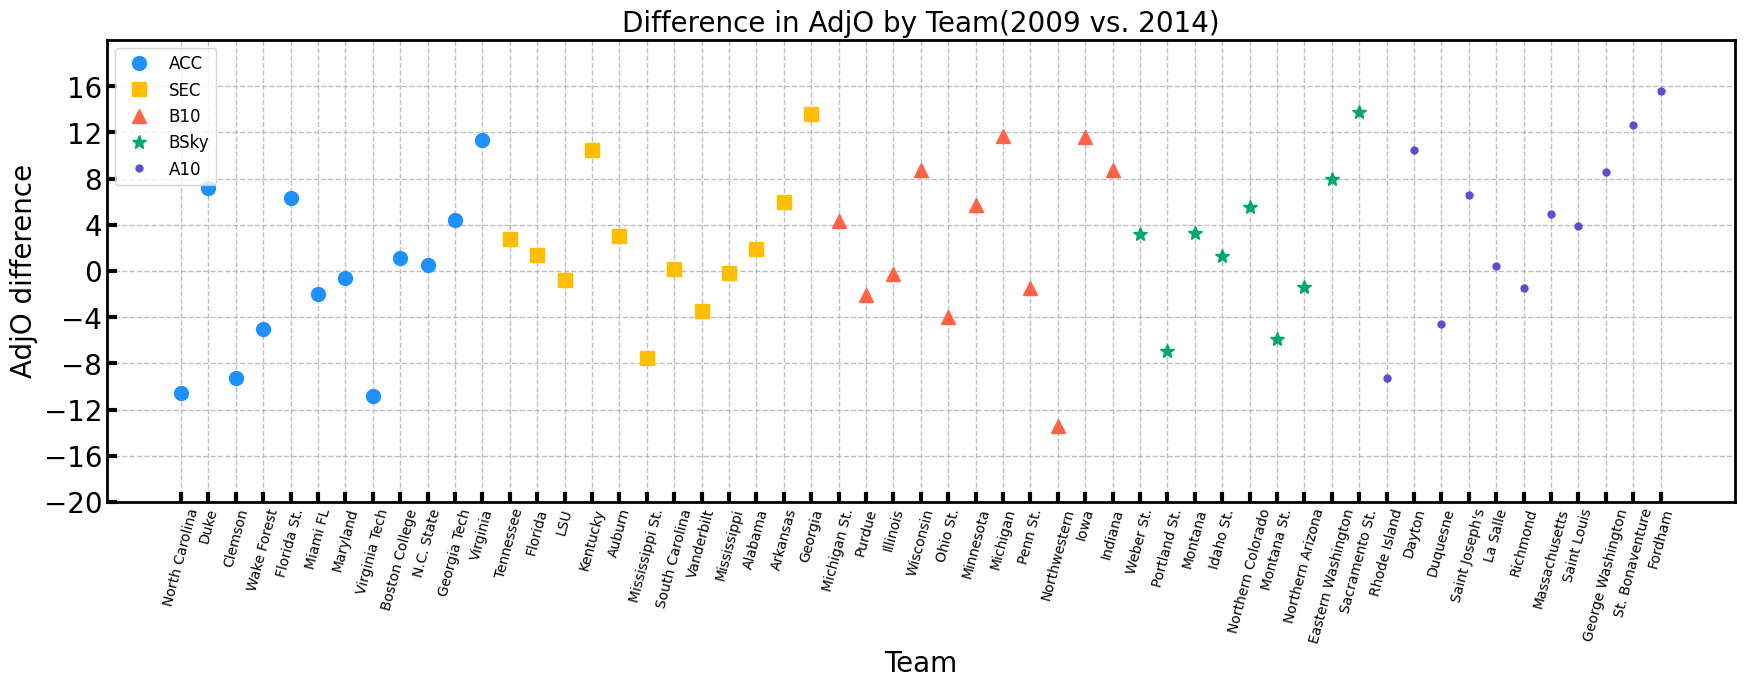

In [12]:
def plot_2009_2014_teams(conferences):
    adjO_diffs, _ = adjO_kernel(dfs['2009'], dfs['2014'], conferences)
    
    setMplParam(len(conferences))
    fig, ax = plt.subplots(figsize=(21, 6))
    for conf in conferences:
       diff = adjO_diffs[conf].dropna()
       ax.plot(diff.index, diff.values, label=conf, linestyle = '')
    
    ax.set_xlabel('Team')
    ax.set_ylabel('AdjO difference')
    ax.set_title('Difference in AdjO by Team(2009 vs. 2014)')
    END = 20
    ax.set_yticks(np.arange(-END, END, 4))
    ax.set_ylim((-END, END))
    ax.legend()
    plt.xticks(rotation=75, fontsize=10)


plot_2009_2014_teams(conferences_5)

* `plot_2009_2014` plots the difference in AdjO between 2009 and 2014 by team versus the value of Adjo in 2009

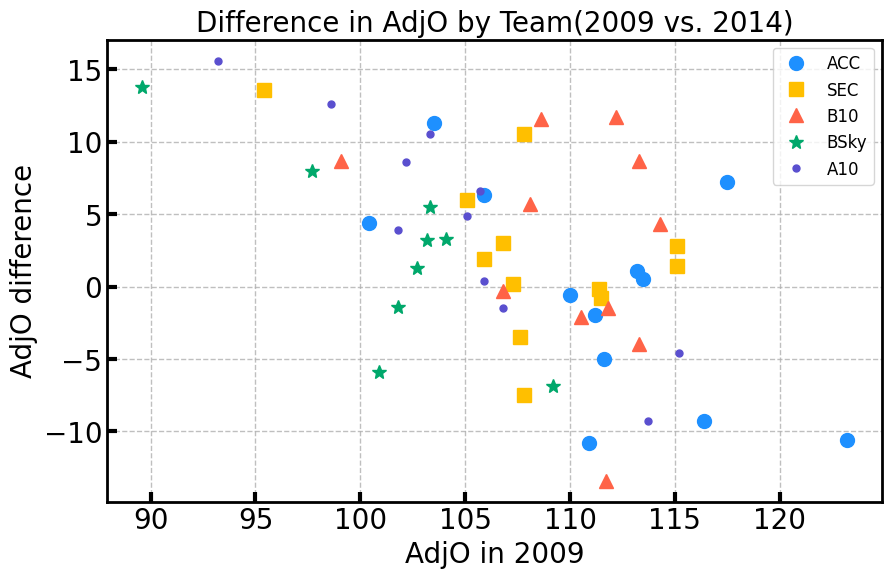

In [13]:
def plot_2009_2014(conferences):
    adjO_diffs, adjO_09 = adjO_kernel(dfs['2009'], dfs['2014'], conferences)

    setMplParam(len(conferences))

    fig, ax = plt.subplots(figsize=(10, 6))
    for i, conf in enumerate(conferences):
       ax.plot(adjO_09[conf], adjO_diffs[conf], label=conf, linestyle = '')
    
    ax.set_xlabel('AdjO in 2009')
    ax.set_ylabel('AdjO difference')
    ax.set_title('Difference in AdjO by Team(2009 vs. 2014)')
    ax.legend()

plot_2009_2014(conferences_5)


* `stats2009_2014` gets the stats of difference in AdjO from data of 2009 and 2014

In [14]:
def stats2009_2014(conferences):
    df09 = dfs['2009']
    df14 = dfs['2014']
    adjO_diffs, _ = adjO_kernel(df09, df14, conferences)

    for conf in conferences:
        print('----'+conf+'-------------')
        print(f'&mean   & {adjO_diffs[conf].mean():.3f}')
        print(f'&median & {adjO_diffs[conf].median():.3f}')
        
    
    condition_others_09 = ~df09['Conf'].isin(conferences)
    df09_others = df09[condition_others_09].set_index('Team')['AdjO']

    condition_others_14 = ~df14['Conf'].isin(conferences)
    df14_others = df14[condition_others_14].set_index('Team')['AdjO']

    common_others = df09_others.index.intersection(df14_others.index)

    adjO_diffs_others = df14_others.loc[common_others] - df09_others.loc[common_others]

    print('----others----------')
    print(f'&mean   & {adjO_diffs_others.mean():.3f}')
    print(f'&median & {adjO_diffs_others.median():.3f}')


stats2009_2014(conferences_5)


----ACC-------------
&mean   & -0.625
&median & -0.050
----SEC-------------
&mean   & 2.283
&median & 1.650
----B10-------------
&mean   & 2.673
&median & 4.300
----BSky-------------
&mean   & 2.322
&median & 3.200
----A10-------------
&mean   & 4.336
&median & 4.900
----others----------
&mean   & 2.595
&median & 1.900


# Ex3

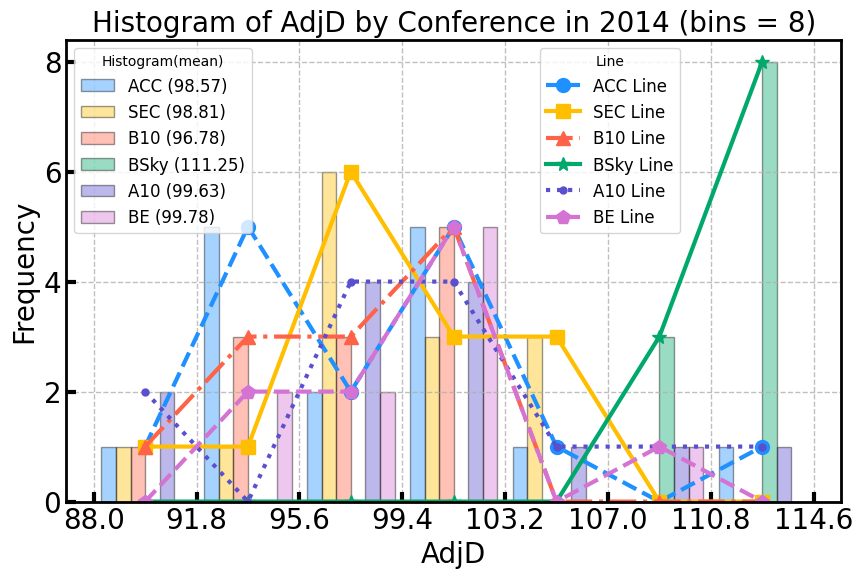

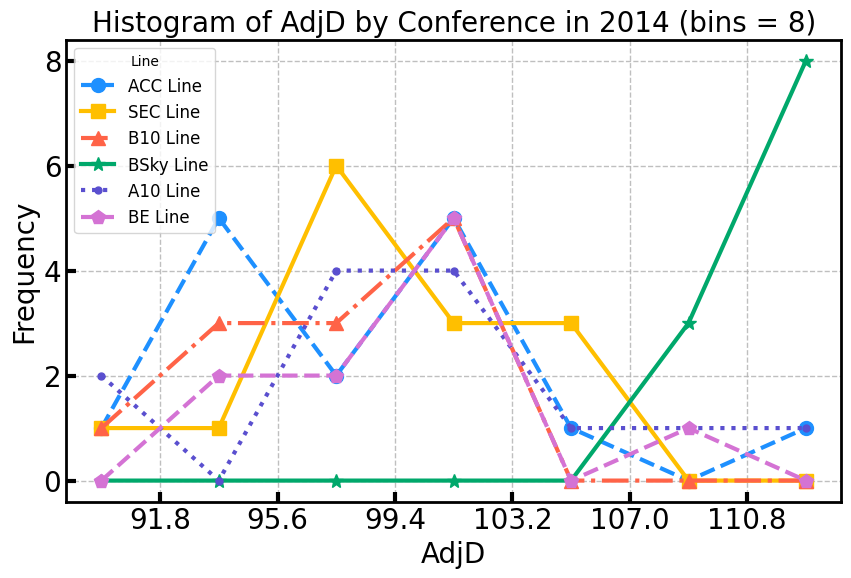

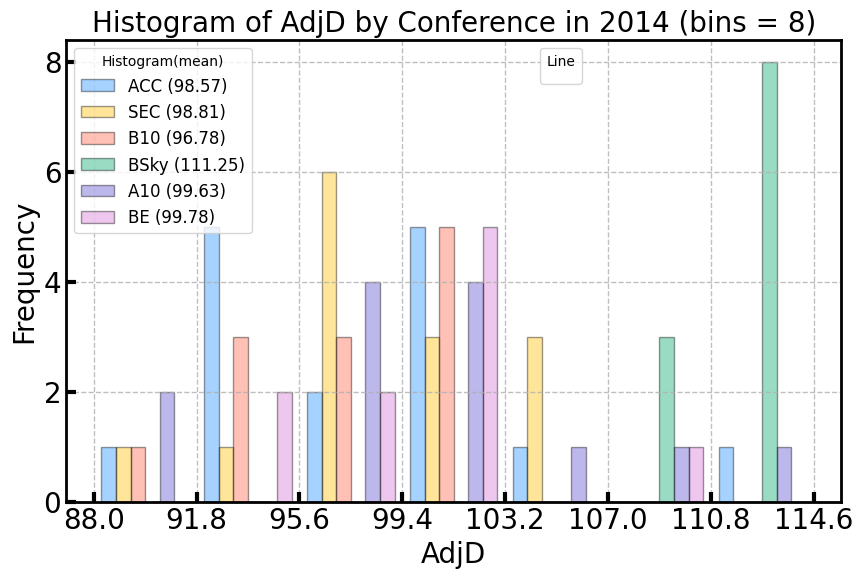

----ACC-------------
&mean   & -0.625
&median & -0.050
----SEC-------------
&mean   & 2.283
&median & 1.650
----B10-------------
&mean   & 2.673
&median & 4.300
----BSky-------------
&mean   & 2.322
&median & 3.200
----A10-------------
&mean   & 4.336
&median & 4.900
----BE-------------
&mean   & 1.143
&median & 1.900
----others----------
&mean   & 2.624
&median & 1.850


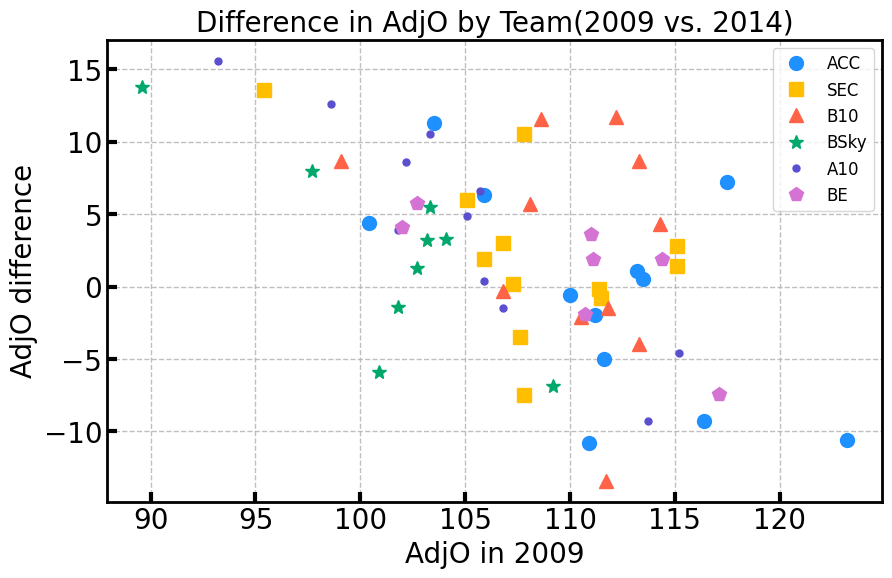

In [33]:

# repeat Ex1
stats2014_bar(conferences_6, isBar=True)
stats2014_bar(conferences_6, isBar=False)
stats2014_bar(conferences_6, isBar=True, isBoth=False)

# repeat Ex2
plot_2009_2014(conferences_6)
stats2009_2014(conferences_6)

# Ex4

* `processOutput` processes `output.txt` to generate `processed_output.txt`

In [15]:
def processOutput(input, output):
    with open(input, 'r', encoding='utf-8') as file:
        lines = file.readlines()

    # Initialize an array to hold the processed lines
    processed_lines = []

    i = 0
    while i < len(lines):
        line = lines[i].strip()

        # Skip lines that match specific patterns (e.g., only a comma or patterns like "(contents),")
        if re.match(r'^\(\w*\),?$', line) or line == ',':
            i += 1
            continue

        # Concatenate lines not ending with a comma with the next line, if applicable
        if not line.endswith(',') and i < len(lines) - 1:
            next_line = lines[i + 1].strip()
            if next_line and next_line != ',':
                line += " " + next_line
                i += 1  # Skip the next line since it's concatenated

        processed_lines.append(line)
        i += 1

    # Remove empty lines and lines starting with "AND" after removing contents in parentheses
    final_lines = [re.sub(r'^AND\s|\(.*?\)', '', line).strip() for line in processed_lines if line and not line.startswith('AND(')]
    final_lines = [line for line in final_lines if line]  # Remove any empty lines resulted from previous step

    # Save the processed lines to the output file
    with open(output, 'w', encoding='utf-8') as file:
        file.write('\n'.join(final_lines))


* `findMiddle` finds the middle name

In [16]:
def findMiddle(file_path):
    # Read the content of the file
    with open(file_path, 'r', encoding='utf-8') as file:
        lines = file.readlines()

    # Extract names, assuming each name ends with a comma
    names = [line.strip().rstrip(',') for line in lines if line.strip().endswith(',')]

    # Sort the names alphabetically
    sorted_names = sorted(names)

    # Find the middle name
    middle_name_index = len(sorted_names) // 2
    middle_name = sorted_names[middle_name_index]

    return middle_name

In [17]:
def readPDF():
    input = 'resources/output.txt'
    output = 'resources/processed_output.txt'
    processOutput(input, output)
    middle_name = findMiddle(output)
    print(middle_name)
readPDF()

K. GILL
